# About Dataset

The ultimate Soccer database for data analysis and machine learning:

* +25,000 matches
* +10,000 players
* 11 European Countries with their lead championship
* Seasons 2008 to 2016
* Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
* Team line up with squad formation (X, Y coordinates)
* Betting odds from up to 10 providers
* Detailed match events (goal types, possession, corner, cross, fouls, cards etc…) for +10,000 matches

## Motivation
I'll use this script to provide introduction to data analysis using SQL language, which should be a must tool for every data scientist - both for getting access to data, but more interesting, as a simple tool for advance data analysis. The logic behind SQL is very similar to any other tool or language that used for data analysis (excel, Pandas), and for those that used to work with data, should be very intuitive.



SQL is a conceptual language for working with data stored in databases. In this project SQLite is the specific implementation. Most SQL languges share all of the capabilities in this doc. The differences are usually in performance and advances analytical funcionalities (and pricing of course). Eventually, I will use SQL lunguage to write queries that would **pull data from the DB, manipulate it, sort it, and extract it**.

The most important component of the DB is its tables - that's where all the data stored. Usually the data would be devided to many tables, and not stored all in one place (so designing the data stracture properly is very important). Most of this script would handle how to work with tables. Other than tables, there are some other very useful concepts/features that we won't cover here:

* Table creation
* inserting / updating data in the DB
* functions - gets a value as an input, and returns manipulation of that value (for example function that remove white spaces)

In [217]:
#Improts 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

path = "/Users/AbdurRahman/Downloads/untitled folder/database.sqlite"  #Insert path here
database = path 

## First I will create the connection to the DB, and see what tables we have in this DB

In [78]:
conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


## List of countries


In [79]:
countries = pd.read_sql("""SELECT *
                        FROM Country;""", conn)
countries

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


## List of leagues and their country

* JOIN is used to connect two tables to each other.
* (INNER) JOIN - keep only records that match the condition (after the ON) in both the tables, and records in both tables that do not match wouldn't appear in the output
* Specify the common value that is used to connect the tables (the ID of the country in that case).

In [89]:

leagues = pd.read_sql("""SELECT *
                        FROM League AS l
                        INNER JOIN Country AS c
                        ON l.country_id = c.id;""", conn)
leagues

,id,country_id,name,id,name
0,1,1,Belgium Jupiler League,1,Belgium
1,1729,1729,England Premier League,1729,England
2,4769,4769,France Ligue 1,4769,France
3,7809,7809,Germany 1. Bundesliga,7809,Germany
4,10257,10257,Italy Serie A,10257,Italy
5,13274,13274,Netherlands Eredivisie,13274,Netherlands
6,15722,15722,Poland Ekstraklasa,15722,Poland
7,17642,17642,Portugal Liga ZON Sagres,17642,Portugal
8,19694,19694,Scotland Premier League,19694,Scotland
9,21518,21518,Spain LIGA BBVA,21518,Spain


## List of teams



In [98]:
teams = pd.read_sql("""SELECT *
                        FROM Team
                        ORDER BY team_long_name 
                        LIMIT 10;""", conn)
teams

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,16848,8350,29,1. FC Kaiserslautern,KAI
1,15624,8722,31,1. FC Köln,FCK
2,16239,8165,171,1. FC Nürnberg,NUR
3,16243,9905,169,1. FSV Mainz 05,MAI
4,11817,8576,614,AC Ajaccio,AJA
5,11074,108893,111989,AC Arles-Avignon,ARL
6,49116,6493,1714,AC Bellinzona,BEL
7,26560,10217,650,ADO Den Haag,HAA
8,9537,8583,57,AJ Auxerre,AUX
9,9547,9829,69,AS Monaco,MON


## List of matches

* Some of the cells have the same name (Country.name,League.name). Therefore, I will rename them using AS.

* As you can see, this query has much more joins. The reasons is because the DB is designed in a star structure - one table (Match) with all the "performance" and metrics, but only keys and IDs, while all the descriptive information stored in other tables (Country, League, Team)

* And also note that Team is joined twice. This is because while I am using the same table name but also bring two different copies (and rename them using AS). The reason is that I need to bring information about two different values (home_team_api_id, away_team_api_id), and if I join them to the same table, it would mean that they are equal to each other.

* Team tables are joined using left join. The reason is that I would prefer to keep the matches in the output - even if one of the teams is missing from the Team table for some reason.

In [116]:
detailed_matches = pd.read_sql("""SELECT m.id, 
                                        c.name AS country_name, 
                                        l.name AS league_name, 
                                        season, 
                                        stage, 
                                        date,
                                        HT.team_long_name AS  home_team,
                                        AT.team_long_name AS away_team,
                                        home_team_goal, 
                                        away_team_goal                                        
                                FROM Match AS m
                                INNER JOIN Country AS c
                                on m.country_id = c.id 
                                INNER JOIN League AS l
                                on m.league_id = l.id 
                                LEFT JOIN Team AS HT 
                                on HT.team_api_id = m.home_team_api_id
                                LEFT JOIN Team AS AT 
                                on AT.team_api_id = m.away_team_api_id
                                WHERE country_name = 'Spain'
                                ORDER by date
                                LIMIT 10;""", conn)
detailed_matches

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,21518,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-30 00:00:00,Valencia CF,RCD Mallorca,3,0
1,21525,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-30 00:00:00,RCD Espanyol,Real Valladolid,1,0
2,21519,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,CA Osasuna,Villarreal CF,1,1
3,21520,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,RC Deportivo de La Coruña,Real Madrid CF,2,1
4,21521,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,CD Numancia,FC Barcelona,1,0
5,21522,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Racing Santander,Sevilla FC,1,1
6,21523,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Real Sporting de Gijón,Getafe CF,1,2
7,21524,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Real Betis Balompié,RC Recreativo,0,1
8,21526,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Athletic Club de Bilbao,UD Almería,1,3
9,21527,Spain,Spain LIGA BBVA,2008/2009,1,2008-08-31 00:00:00,Atlético Madrid,Málaga CF,4,0


## Let's do some basic analytics

Here I will be exploring the data at more aggregated level. Instead of looking on the raw data I will start to grouping it to different levels we want to examine. In this section, I will base it on the previous query, remove the match and date information, and look at it at the **country-league-season level**.

The functionality we will use for that is **GROUP BY**.

Once I chose what level I want to analyse, I can devide the SELECT statement to two:

* Dimensions - those are the values I will be describing, same that I will group by later.

* Metrics - all the metrics have to be aggregated using functions. The common functions are: sum(), count(), count(distinct ...), avg(), min(), max()

/*Note - it is very important to use the same dimensions both in the SELECT, and in the GROUP BY. Otherwise the output might be wrong*/.

Another functionality that can be used after grouping, is **HAVING**. This adds another layer of filtering the data. Having is also useful funcation in terms of cleaning the output.

In [128]:
leages_by_season = pd.read_sql("""SELECT C.name AS country_name, 
                                        l.name AS league_name, 
                                        season,
                                        count(distinct stage) AS number_of_stages,
                                        count(distinct HT.team_long_name) AS number_of_teams,
                                        avg(home_team_goal) AS avg_home_team_scors, 
                                        avg(away_team_goal) AS avg_away_team_goals, 
                                        avg(home_team_goal-away_team_goal) AS avg_goal_dif, 
                                        avg(home_team_goal+away_team_goal) AS avg_goals, 
                                        sum(home_team_goal+away_team_goal) AS total_goals                                       
                                FROM Match AS m
                                JOIN Country AS c 
                                on m.country_id = c.id  
                                JOIN League AS l
                                on  m.league_id = l.id 
                                LEFT JOIN Team AS HT 
                                on  m.home_team_api_id = HT.team_api_id 
                                LEFT JOIN Team AS AT 
                                on  m.away_team_api_id = AT.team_api_id 
                                WHERE country_name in ('Spain', 'Germany', 'France', 'Italy', 'England')
                                GROUP BY c.name, l.name, season
                                HAVING count(distinct stage) > 10
                                ORDER BY c.name, l.name, season DESC
                                ;""", conn)
leages_by_season



,country_name,league_name,season,number_of_stages,number_of_teams,avg_home_team_scors,avg_away_team_goals,avg_goal_dif,avg_goals,total_goals
0,England,England Premier League,2015/2016,38,20,1.492105,1.207895,0.284211,2.700000,1026
1,England,England Premier League,2014/2015,38,20,1.473684,1.092105,0.381579,2.565789,975
2,England,England Premier League,2013/2014,38,20,1.573684,1.194737,0.378947,2.768421,1052
3,England,England Premier League,2012/2013,38,20,1.557895,1.239474,0.318421,2.797368,1063
4,England,England Premier League,2011/2012,38,20,1.589474,1.215789,0.373684,2.805263,1066
5,England,England Premier League,2010/2011,38,20,1.623684,1.173684,0.450000,2.797368,1063
6,England,England Premier League,2009/2010,38,20,1.697368,1.073684,0.623684,2.771053,1053
7,England,England Premier League,2008/2009,38,20,1.400000,1.078947,0.321053,2.478947,942
8,France,France Ligue 1,2015/2016,38,20,1.436842,1.089474,0.347368,2.526316,960
9,France,France Ligue 1,2014/2015,38,20,1.410526,1.081579,0.328947,2.492105,947


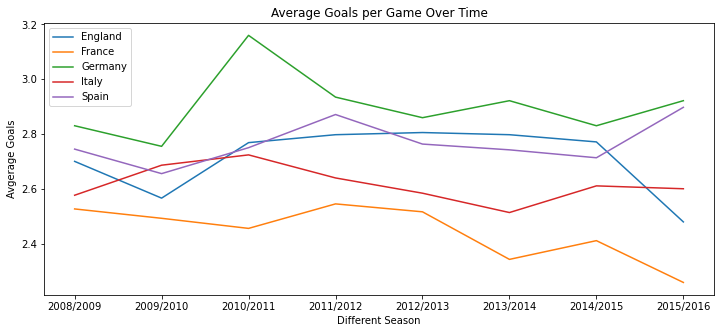

In [195]:
df = pd.DataFrame(index=np.sort(leages_by_season['season'].unique()), columns=leages_by_season['country_name'].unique())

df.loc[:,'Germany'] = list(leages_by_season.loc[leages_by_season['country_name']=='Germany','avg_goals'])
df.loc[:,'Spain']   = list(leages_by_season.loc[leages_by_season['country_name']=='Spain','avg_goals'])
df.loc[:,'France']   = list(leages_by_season.loc[leages_by_season['country_name']=='France','avg_goals'])
df.loc[:,'Italy']   = list(leages_by_season.loc[leages_by_season['country_name']=='Italy','avg_goals'])
df.loc[:,'England']   = list(leages_by_season.loc[leages_by_season['country_name']=='England','avg_goals'])

plt.figure(figsize=(12, 5))
plt.plot(df)
plt.title('Average Goals per Game Over Time')
plt.xlabel('Different Season')
plt.ylabel('Avgerage Goals')
plt.legend(df)
plt.show()
           



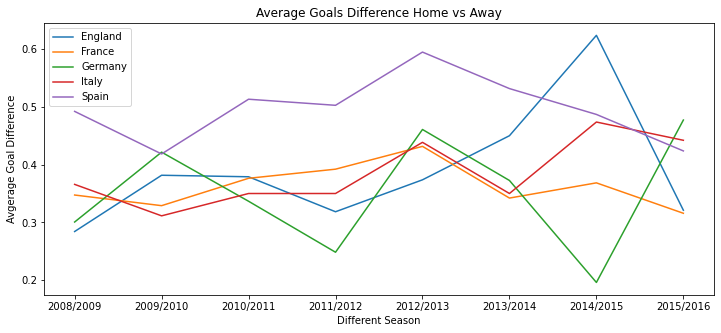

In [218]:
df = pd.DataFrame(index=np.sort(leages_by_season['season'].unique()), columns=leages_by_season['country_name'].unique())

df.loc[:,'Germany'] = list(leages_by_season.loc[leages_by_season['country_name']=='Germany','avg_goal_dif'])
df.loc[:,'Spain']   = list(leages_by_season.loc[leages_by_season['country_name']=='Spain','avg_goal_dif'])
df.loc[:,'France']   = list(leages_by_season.loc[leages_by_season['country_name']=='France','avg_goal_dif'])
df.loc[:,'Italy']   = list(leages_by_season.loc[leages_by_season['country_name']=='Italy','avg_goal_dif'])
df.loc[:,'England']   = list(leages_by_season.loc[leages_by_season['country_name']=='England','avg_goal_dif'])


plt.figure(figsize=(12, 5))
plt.plot(df)
plt.title('Average Goals Difference Home vs Away')
plt.xlabel('Different Season')
plt.ylabel('Avgerage Goal Difference')
plt.legend(df)
plt.show()
           

## Sub Queries and Functions

/*In this section I will be using subqueries, which is an essential tool in SQL, as it allows manipulating the data in very advanced ways without the need of any external scripts, and especially important when your tables stractured in such a way that can't be joined directly*/.

In our example, I'm trying to join between a table that holds players' basic details **(name, height, weight)**, to a table that holds more attributes. However, the problem is that while the first table holds one row for each player, the key in the second table is player+season, so if I do a regular join, the result would be a cartesian product, and each player's basic details would appear as many times as this player appears in the attributes table. **The result would be that the average would be skewed towards players that appear many times in the attribute table**.

Therefore, the solution is to use a subquery. I would need to group the attributes table, to a different key - player level only (without season). And Of course I would need to decide first how I would want to combine all the attributes to a single row. I used average, but one can also decide on maximum, latest season and etc. Once both tables have the same keys, I will then join them together.

**In addition, I will show how to use functions such as:**

* Conditional function is an important tool for data manipulation. While IF statement is very popular in other languages,  but SQLite is not supporting it, and it's implemented by using CASE + WHEN + ELSE statement. As you can see, based on the input of the data, the query would return different results.

* ROUND function. 



In [249]:
players_height = pd.read_sql("""SELECT CASE
                                        WHEN ROUND(height)<165 then 165
                                        WHEN ROUND(height)>195 then 195
                                        ELSE ROUND(height)
                                        END AS calc_height, 
                                        COUNT(height) AS distribution, 
                                        (avg(PA_Grouped.avg_overall_rating)) AS avg_overall_rating,
                                        (avg(PA_Grouped.avg_potential)) AS avg_potential,
                                        AVG(weight) AS avg_weight 
                            FROM PLAYER AS p
                            LEFT JOIN (SELECT pa.player_api_id, 
                                        avg(pa.overall_rating) AS avg_overall_rating,
                                        avg(pa.potential) AS avg_potential  
                                        FROM Player_Attributes AS pa
                                        GROUP BY pa.player_api_id) 
                                        AS PA_Grouped 
                                        ON p.player_api_id = PA_Grouped.player_api_id
                            GROUP BY calc_height
                            ORDER BY calc_height
                                ;""", conn)
players_height

,calc_height,distribution,avg_overall_rating,avg_potential,avg_weight
0,165.0,74,67.365543,73.327754,139.459459
1,168.0,118,67.500518,73.124182,144.127119
2,170.0,403,67.726903,73.379056,147.799007
3,173.0,530,66.980272,72.848746,152.824528
4,175.0,1188,66.805204,72.258774,156.111953
5,178.0,1489,66.367212,71.943339,160.665547
6,180.0,1388,66.419053,71.846394,165.261527
7,183.0,1954,66.634380,71.754555,170.167861
8,185.0,1278,66.928964,71.833475,174.636933
9,188.0,1305,67.094253,72.151949,179.278161


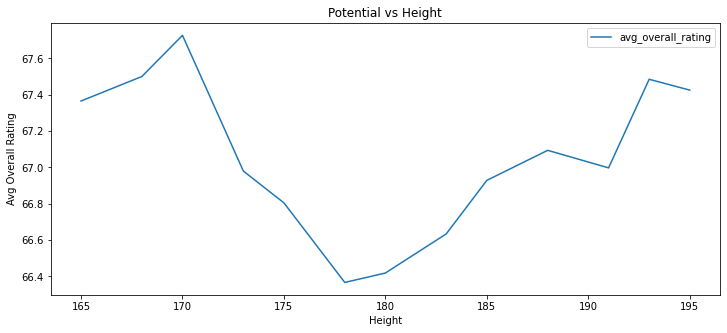

In [259]:
players_height.plot(x='calc_height',y='avg_overall_rating',figsize=(12,5))
plt.title('Potential vs Height')
plt.xlabel('Height')
plt.ylabel('Avg Overall Rating')
plt.show()
